### And now to build some models

In [2]:
#import everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#pull in our formatted train data
df = pd.read_csv('out_train_v2.csv')

In [4]:
#and our formatted test data
df1 = pd.read_csv('out_test_v2.csv')

In [5]:
df1.ix[df1.Species.str.contains("UNSPECIFIED CULEX"), 'Species'] = "CULEX PIPIENS/RESTUANS"


In [6]:
#let's first establish our y variable
X = df.drop("WnvPresent", axis=1)
y = df.WnvPresent

In [7]:
#creating a variable to determine what the variance in temperature was on any given day
X["TVar"] = X["Tmax"] - X["Tmin"]

In [8]:
#and the same for our test data
df1["TVar"] = df1['Tmax'] - df1['Tmin']

In [9]:
#converting species and trap to categorical data
X.Species = X.Species.astype('category')

# X.Species = X.Species.cat.codes

In [10]:
df1.Species = df1.Species.astype('category')
# df1.Species = df1.Species.cat.codes

In [11]:
test = df1

In [12]:
X = pd.concat([X, pd.get_dummies(X.Species, drop_first=True)], axis=1)


In [13]:
test = pd.concat([test, pd.get_dummies(test.Species, drop_first=True)], axis=1)

In [14]:
#drop the variables we're not going to use
X.head()
X = X.drop(['Unnamed: 0', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Tavg', 'Tmin', 'NumMosquitos', 'DewPoint', 'Trap', 'Species'], axis=1)

In [15]:
#same with test
test = test.drop(['Unnamed: 0','Id', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Tavg', 'Tmin', 'DewPoint', 'Trap', 'Species'], axis=1)

In [16]:
#let's check the dataframe to make sure they're both the same
X.head()

,Latitude,Longitude,Tmax,PrecipTotal,AvgSpeed,length_of_day,TVar,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,41.954690,-87.800991,88,0.0,6.5,896.0,28,0.0,1.0,0.0,0.0,0.0,0.0
1,41.954690,-87.800991,88,0.0,6.5,896.0,28,0.0,0.0,1.0,0.0,0.0,0.0
2,41.994991,-87.769279,88,0.0,6.5,896.0,28,0.0,0.0,1.0,0.0,0.0,0.0
3,41.974089,-87.824812,88,0.0,6.5,896.0,28,0.0,1.0,0.0,0.0,0.0,0.0
4,41.974089,-87.824812,88,0.0,6.5,896.0,28,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
#yep, they are
test.head()

,Latitude,Longitude,Tmax,PrecipTotal,AvgSpeed,length_of_day,TVar,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,41.95469,-87.800991,86,0.0,10.0,910.0,25,0.0,1.0,0.0,0.0,0.0,0.0
1,41.95469,-87.800991,86,0.0,10.0,910.0,25,0.0,0.0,1.0,0.0,0.0,0.0
2,41.95469,-87.800991,86,0.0,10.0,910.0,25,1.0,0.0,0.0,0.0,0.0,0.0
3,41.95469,-87.800991,86,0.0,10.0,910.0,25,0.0,0.0,0.0,1.0,0.0,0.0
4,41.95469,-87.800991,86,0.0,10.0,910.0,25,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
X.shape

(10506, 13)

In [19]:
test.shape

(116293, 13)

In [20]:
#let's start importign everything
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [21]:
#scaling the data to make sure all our data is on the same scale
to_scale = X[['Tmax', 'PrecipTotal', 'AvgSpeed', 'length_of_day', 'TVar']]
scaled = pd.DataFrame(StandardScaler().fit_transform(to_scale), columns=['Tmax_scaled', 'PrecipTotal_scaled', 'AvgSpeed_scaled', 'length_of_day_scaled', 'TVar_scaled'])
X = pd.concat([X, scaled], axis=1)
X = X.drop(['Tmax', 'PrecipTotal', 'AvgSpeed', 'length_of_day', 'TVar'], axis=1)
# scaled.head()

In [22]:
X.shape

(10506, 13)

In [23]:
to_scale = test[['Tmax', 'PrecipTotal', 'AvgSpeed', 'length_of_day', 'TVar']]
scaled = pd.DataFrame(StandardScaler().fit_transform(to_scale), columns=['Tmax_scaled', 'PrecipTotal_scaled', 'AvgSpeed_scaled', 'length_of_day_scaled', 'TVar_scaled'])
test = pd.concat([test, scaled], axis=1)
test = test.drop(['Tmax', 'PrecipTotal', 'AvgSpeed', 'length_of_day', 'TVar'], axis=1)

In [24]:
#IMPORT ALL THE THINGS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc

/Users/rb/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
#set our parameters for gradient boosting
gbc = GradientBoostingClassifier(max_features='sqrt',n_estimators=1000)

In [26]:
#establish names for our confusion matrix
names = ["present", "not present", "predicted present", "predicted not present"]

In [33]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(max_depth=3, n_estimators=130)
#  learning_rate =0.1,
#  max_depth=3,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

In [ ]:
from sklearn.grid_search import GridSearchCV
# xgb = xgboost.XGBClassifier()
from xgboost import XGBClassifier

clf = XGBClassifier()

parameters = {'min_child_weight':[6,8],
'max_depth':[2,3,4],
'min_child_weight':range(1,10,1),
'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)],
'learning_rate': [0.01, 0.02, 0.03, 0.05,0.1],
'n_estimators': range(100,200,30)}
grid = GridSearchCV(clf, parameters, n_jobs=1, scoring='roc_auc', cv=3)

grid_coef = grid.fit(X, y)
print(grid)
grid.best_score_ 
grid.best_params_

0.943178540525
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.658598    0.341402                    1
1    0.880524    0.119476                    1
2    0.999830    0.000170                    0
3    0.996952    0.003048                    0
4    0.982925    0.017075                    0
5    0.999550    0.000450                    0
6    0.998756    0.001244                    0
7    0.999598    0.000402                    0
8    0.999982    0.000018                    0
9    0.999711    0.000289                    0
             predicted present  predicted not present
present                    130                     52
not present                676                   2609
             precision    recall  f1-score   support

          0       0.98      0.79      0.88      3285
          1       0.16      0.71      0.26       182

avg / total       0.94      0.79      0.85      3467

(3467, 3)
        Latitude  Longitude  CULEX PIPIENS  CULEX PIPIENS/RESTUANS  \
10156  41.9

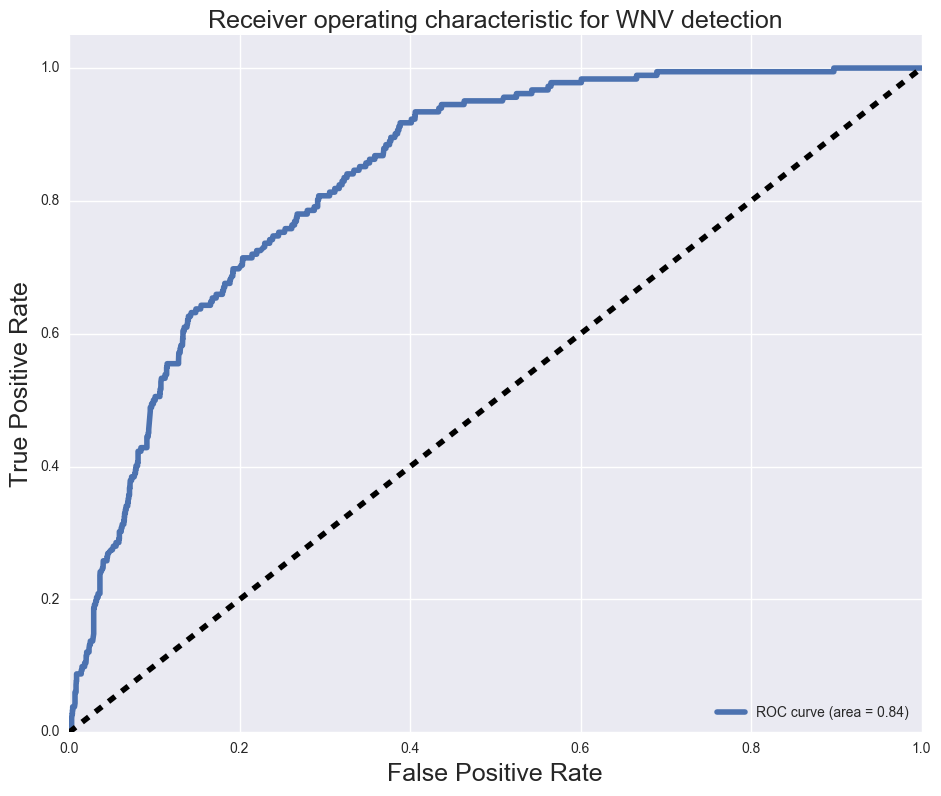

('cross val mean score is', 0.94288924694708276)

In [28]:
#pull up this monster of a function again to take a look at our train data and generate the model we think is best
def evaluate_model(model, X, y, names, test):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=7)
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print model.score(X_test, Y_test)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    Y_pp['pred_class_thresh10'] = [1 if x >= 0.05 else 0 for x in Y_pp.class_1_pp.values]
    X_test_df = pd.DataFrame(X_test)
    conmat = np.array(confusion_matrix(Y_test, Y_pp.pred_class_thresh10, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=[names[0:2]],
                         columns=[names[2:]]) 
    print(Y_pp.iloc[0:10])
    print confusion
    print(classification_report(Y_test, Y_pp.pred_class_thresh10))
    print Y_pp.shape
    print X_test_df.head()
    
    Y_score = model.decision_function(X_test)

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

# For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for WNV detection', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    return "cross val mean score is", cross_val_score(model, X_train, Y_train, cv=5).mean()
    
    


evaluate_model(gbc, X, y, names, test)

In [34]:
evaluate_model(xgb, X, y, names, test)

0.947505047592
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.794687    0.205313                    1
1    0.869505    0.130495                    1
2    0.997553    0.002447                    0
3    0.968299    0.031701                    0
4    0.939659    0.060341                    1
5    0.985826    0.014174                    0
6    0.993873    0.006127                    0
7    0.999331    0.000669                    0
8    0.999537    0.000463                    0
9    0.999559    0.000441                    0
             predicted present  predicted not present
present                    147                     35
not present                908                   2377
             precision    recall  f1-score   support

          0       0.99      0.72      0.83      3285
          1       0.14      0.81      0.24       182

avg / total       0.94      0.73      0.80      3467

(3467, 3)
        Latitude  Longitude  CULEX PIPIENS  CULEX PIPIENS/RESTUANS  \
10156  41.9

AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

### Prep model for submission!

In [37]:
#fit the model and get the predicted probabilities
model = xgb.fit(X, y, eval_metric="auc")
y_pred = model.predict_proba(test)

In [ ]:
#also get the predictions in general
y_predicted = model.predict(test)

In [ ]:
X.head()

In [38]:
#just a tiny peak at what the model thought were the most important features
#looks like it's species, trap and length of day
model.feature_importances_

array([ 0.15000001,  0.18289474,  0.01315789,  0.01315789,  0.03289474,
        0.01973684,  0.        ,  0.03552632,  0.10526316,  0.05657895,
        0.13815789,  0.19342105,  0.05921053], dtype=float32)

In [39]:
#creating a dataframe for the y_preds
y_preds = pd.DataFrame(data=y_pred, columns=["WnvNotPresent", "WnvPresent"])

In [40]:
#create a new dataframe merging all our data
df_out = pd.merge(df1, y_preds[['WnvPresent']], how = 'left', left_index=True, right_index=True )
df_out = df_out[['Id', 'WnvPresent']]
df_out.to_csv('xgb_evalmethod.csv', index=False)

In [ ]:
#and one for plotting graphs!
df_plot = pd.merge(df1, y_preds[['WnvPresent']], how='left', left_index = True, right_index=True)

In [ ]:
#the one for plot needs very specific columns
#but we also want to set a threshold for where we think the city of Chicago should spray
#we also wanted the date to be manipulatable 
df_plot = df_plot[['Longitude', 'Latitude', 'Trap', 'Date', 'WnvPresent']]
df_plot["y_or_n"] = [1 if x > 0.3 else 0 for x in df_plot.WnvPresent]
df_plot['Date'] = pd.to_datetime(df_plot['Date'])
df_plot['year'] = df_plot.Date.dt.year
df_plot['month'] = df_plot.Date.dt.month

In [ ]:
#and let's save that
df_plot.to_csv('dfplot_214.csv', index=False)